# 課題6 クラスタリング

配点
- Q1.1 2P
- Q1.2 1P
- Q2.1 2P
- Q2.2 3P
- Q2.3 2P

In [1]:
# モジュールのインポート
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlibでの日本語表示用
from matplotlib import font_manager
fp = font_manager.FontProperties(fname="ipag.ttf")

## Q1 階層化クラスタリング
以下では、課題4で扱った授業データについて授業名間の類似度（距離）に基づき授業を階層化クラスタリングすることを考えます。

### Q1.1 特徴量ベクトル
まず、以下の`tfidf()`関数を準備します。`tfidf()`関数は、課題4と同様に授業名のテキストデータ（"course_list.csv"ファイル）と授業名に含まれるキーワードのデータ（"keyword_list.csv"ファイル）から、各授業のTFIDFベクトルを行とする授業-単語行列を作成する関数です。

`tfidf()`関数は、授業名を要素とするリスト`courses`、キーワードを要素とするリスト`vocab`、授業-単語行列（要素はTFIDF値）、をそれぞれ返します。変数`tfidf`が授業-単語行列（要素はTFIDF値）となるように`tfidf()`関数を完成させてください。

In [8]:
def tfidf():
    # keyword_list.csvの読み込み
    with open('keyword_list.csv', 'r',  encoding="utf-8") as f:
        vocab = [row[0] for row in  csv.reader(f)]

    # course_list.csvの読み込み
    with open('course_list.csv', 'r',  encoding="utf-8") as f:
        courses = [row[0] for row in  csv.reader(f)]

    # TFを要素とする授業-単語行列の作成
    tf = np.zeros((len(courses), len(vocab)), dtype=int)
    for i in range(len(courses)):
        for j in range(len(vocab)):
            if vocab[j] in courses[i]:
                tf[i, j]=courses[i].count(vocab[j])
                
    # 単語のID（リストvocabのその単語のインデックス）をキー、その単語のDF（Document Frequency)を値とする辞書
    dic={}
    for i in range(len(vocab)):
        for course in courses:
            if vocab[i] in course: #courseがvocab[i]を含むという条件:
                if not i in dic:
                    dic[i] = 0
                dic[i] += 1 #dic[i]を1つ増やす
                    #dicにiのキーがまだない場合に注意      
    
    # Q3.2で作成した授業-単語行列の各要素(授業iの単語jの 𝑇𝐹𝑖𝑗)にその単語のIDF値を掛けたTFIDF値を要素とする行列
    # 各授業のTFIDFベクトルを行とする授業-単語行列
    tfidf = np.zeros((len(courses), len(vocab)))
    for i in range(len(courses)):
        for j in range(len(vocab)):
            # その単語のIDF値 = np.log(len(courses)/df[j])
            tfidf[i, j] = tf[i, j]*np.log(len(courses)/dic[j])

    return courses, vocab, tfidf

courses, vocab, tfidf_matrix=tfidf()

授業「総合社会科学高度教養（計量社会科学研究）」には「科学」が2回含まれ(テキストに含まれる単語の出現数)、「科学」のDF値（単語を含むテキストの数）は`412`なので対応する行列の要素の値は$TFIDF=TF*IDF=TF*log(N/DF)=2*log(4678/412)\simeq4.85$となります。

In [9]:
print(tfidf_matrix[courses.index('総合社会科学高度教養（計量社会科学研究）'), vocab.index('科学')])

4.859205195589196


以下の`similar_courses()`関数は、課題4で作成した`find_similar_course()`関数と同様に入力の授業に対してcos類似度に基づいて類似する授業名を探す関数ですが、ここでは以下の辞書を返します。**辞書には入力の授業も含めることに注意してください。**

`sim_courses`:入力の授業および類似授業のインデックスをキー、入力の授業名および類似授業名を値として持つ辞書

`similar_courses()`関数を完成させてください。

In [10]:
# cos類似度を求める関数（課題4参照）
def cos_sim(vec1, vec2):
    return np.dot(vec1, vec2)/np.sqrt(np.sum(vec1**2)*np.sum(vec2**2))

def similar_courses(target, tfidf_matrix, courses):
    ### 引数：
    # target: 入力講義のインデックス
    # tfidf_matrix: TFIDF値が要素の授業単語行列
    # courses: 授業名のリスト    
    
    # 入力の授業および類似授業のインデックスをキー、入力の授業名および類似授業名を値として持つ辞書
    sim_courses={}    
    for i in range(tfidf_matrix.shape[0]):
        if cos_sim(tfidf_matrix[target], tfidf_matrix[i]) > 0:
            sim_courses[i] = courses[i]### 授業インデックスiをキー、授業名courses[i]を値として
            ### 辞書sim_coursesに追加するコード
    return sim_courses

「再生可能エネルギーと公共政策」を入力の授業として`similar_courses()`関数を用いて類似授業を求めると、入力の授業自身も含めて69の授業講義があります。

In [11]:
title="再生可能エネルギーと公共政策" 
sim_courses=similar_courses(courses.index(title), tfidf_matrix, courses) 
print(len(sim_courses))

69


### Q1.2 デンドログラム

以下では、入力の授業について`similar_courses()`関数で取得した類似授業（入力の授業も含む）をデータセットとして、授業名間の類似度（距離）に基づきデータセットを階層化クラスタリングします。

クラスタリングには`SciPy`の階層化クラスタリングモジュール（`scipy.cluster.hierarchy`）を用います。

`linkage`関数は、特徴量ベクトルを行とする行列を入力とし、`metric`引数で指定した距離尺度と`method`引数で指定した距離計算方法で階層化クラスタリングを行い、特徴量ベクトル間のクラスタリングの過程を行列として返します。

- metric引数に指定できる距離尺度: cosine, euclidean, jaccard, hamming, correlation, mahalanobis, など
[linkage関数](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)

- method引数に指定できる距離計算方法: single, complete, average, ward, など
[距離計算方法](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist)

以下では、`linkage`関数の入力を`tfidf_matrix[ind,:]`として、先に抽出した類似授業のTFIDFベクトルを行とする授業-単語行列を指定しています。

`dendrogram`関数は、`linkage`関数が出力したクラスタリング過程を表す行列を入力として、クラスタリングの過程をデンドログラムとして可視化します。`labels`引数には各特徴量ベクトルに付与するラベルのリストを指定します。

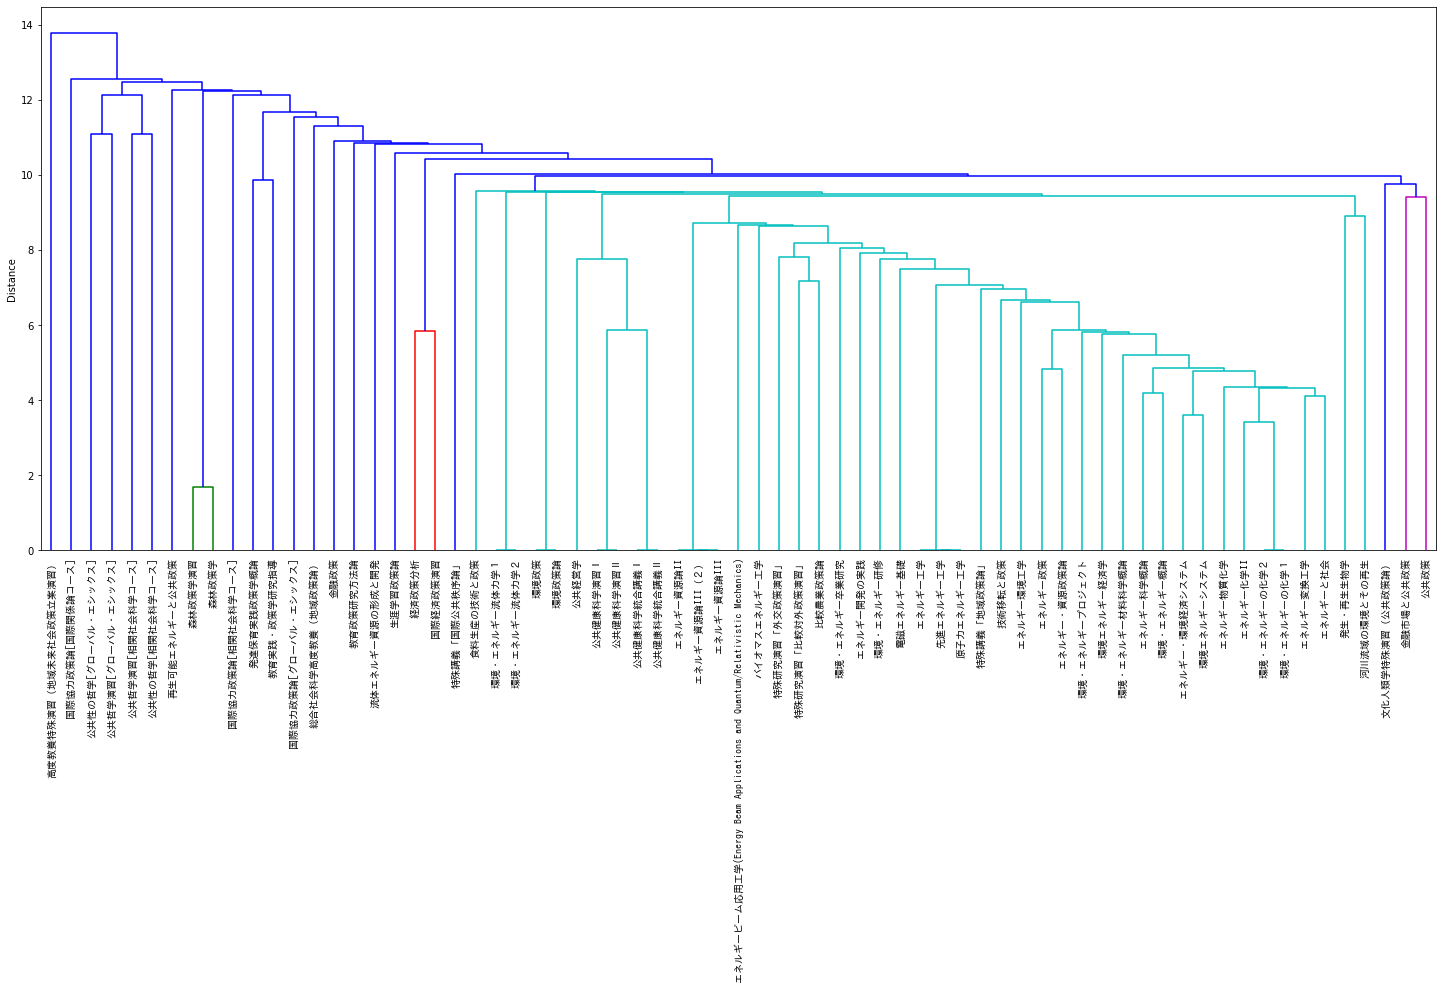

In [12]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

courses, vocab, tfidf_matrix=tfidf()
title="再生可能エネルギーと公共政策" 
sim_courses=similar_courses(courses.index(title), tfidf_matrix, courses)
ind=[] # 類似授業のインデックスのリスト
labels=[] # 類似授業名のリスト
for k, v in sim_courses.items():
    ind.append(k)
    labels.append(v)

# 階層化クラスタリング
# 距離尺度を'euclidean'、距離計算は'single'
clusters = linkage(tfidf_matrix[ind,:], metric = 'euclidean', method = 'single')

# デンドログラム
plt.figure(figsize=(25,10))
dend = dendrogram(clusters,  labels=labels)
for l in plt.gca().get_xticklabels(): l.set_fontproperties(fp) # ラベルを日本語表示
plt.ylabel('Distance');

距離計算方法を`complete`や`average`に変更して階層化クラスタリングを行い、得られるクラスタがどのように変化するか、それぞれのデンドログラムを可視化して観察してください。

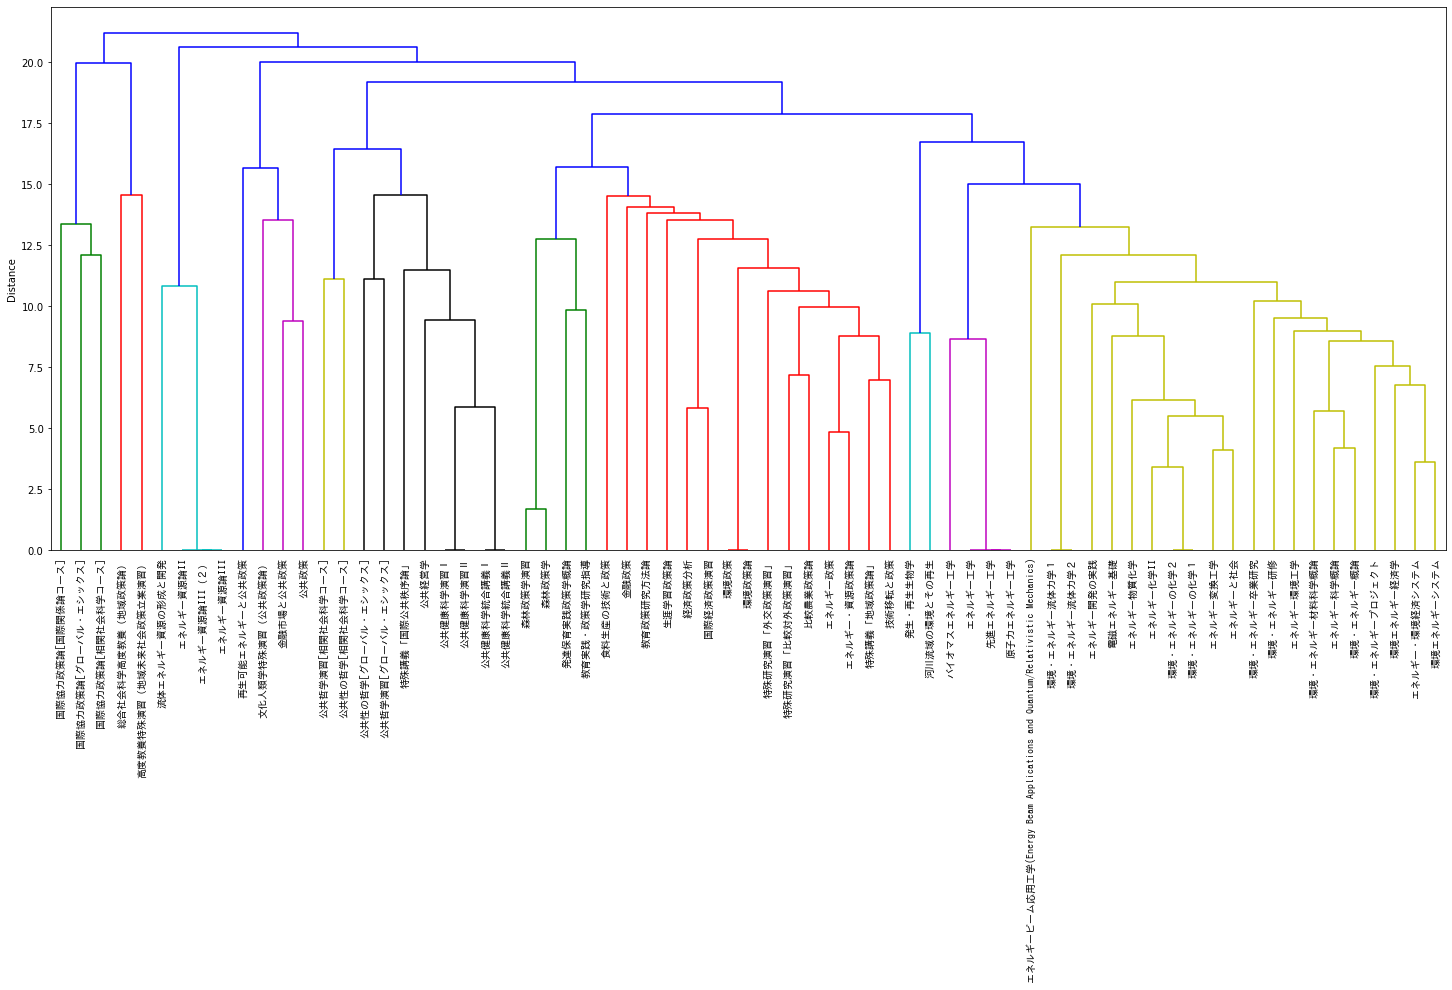

In [13]:
"""
# 階層化クラスタリング
# 距離尺度を'euclidean'、距離計算は'single'
clusters = linkage(tfidf_matrix[ind,:], metric = 'euclidean', method = 'single')
"""

#距離計算方法をcompleteやaverageに変更して階層化クラスタリングを行い、
#それぞれのデンドログラムを可視化して観察してください。
clusters = linkage(tfidf_matrix[ind,:], metric = 'euclidean', method = 'complete')
#clusters = ### 距離計算方法を指定してクラスタリング ###

# デンドログラム
plt.figure(figsize=(25,10))
dend = dendrogram(clusters,  labels=labels)
for l in plt.gca().get_xticklabels(): l.set_fontproperties(fp) 
plt.ylabel('Distance');

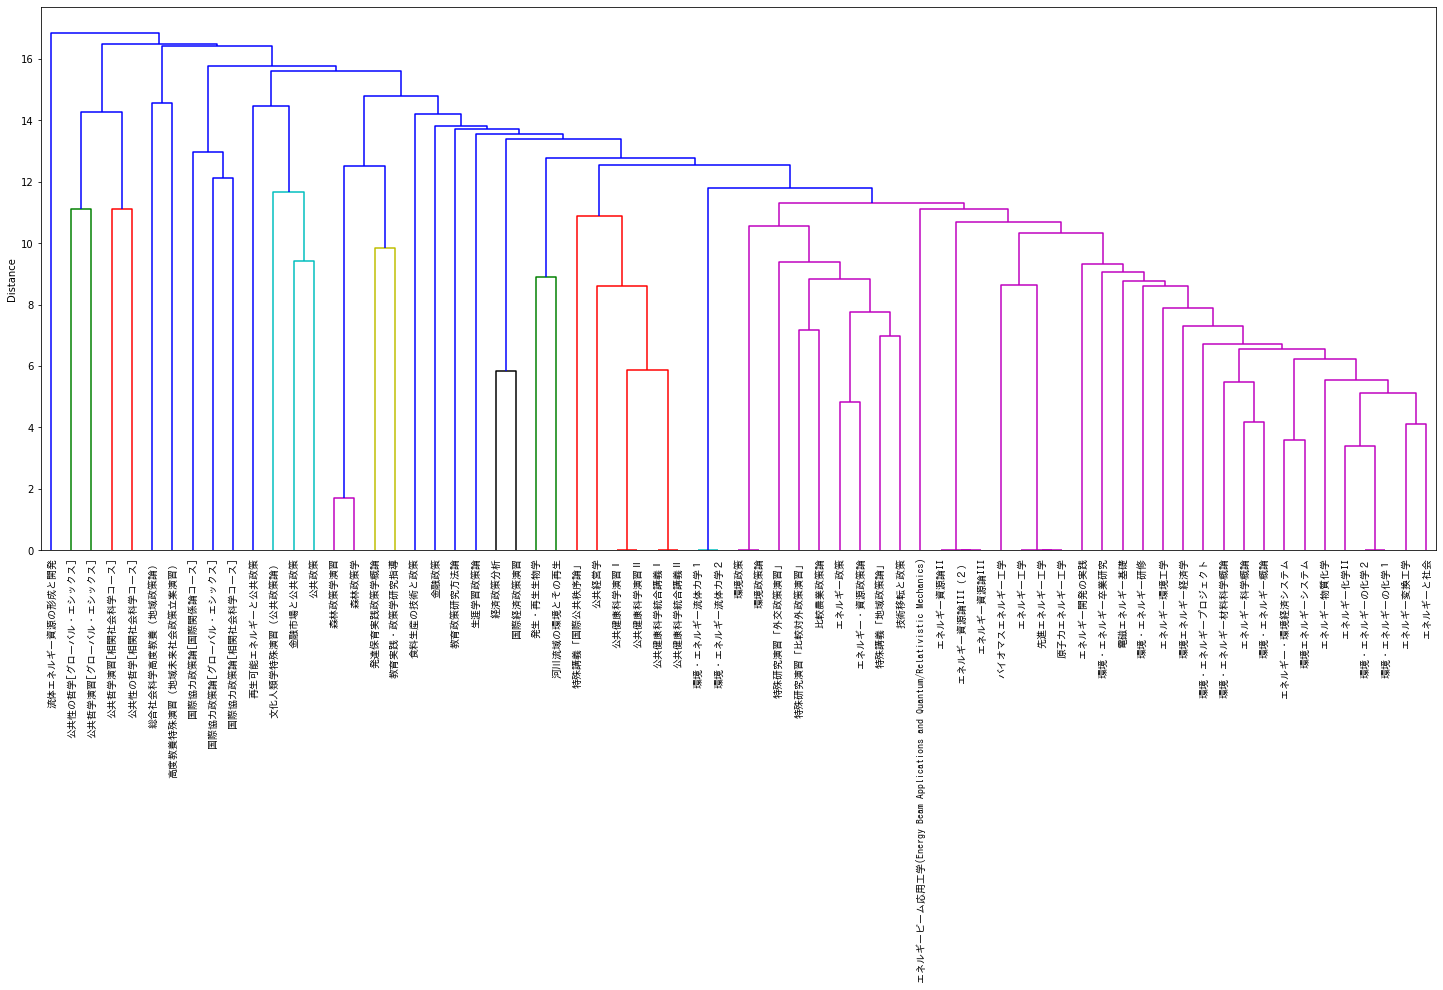

In [14]:
"""
# 階層化クラスタリング
# 距離尺度を'euclidean'、距離計算は'single'
clusters = linkage(tfidf_matrix[ind,:], metric = 'euclidean', method = 'single')
"""

#距離計算方法をcompleteやaverageに変更して階層化クラスタリングを行い、
#それぞれのデンドログラムを可視化して観察してください。
clusters = linkage(tfidf_matrix[ind,:], metric = 'euclidean', method = 'average')
#clusters = ### 距離計算方法を指定してクラスタリング ###

# デンドログラム
plt.figure(figsize=(25,10))
dend = dendrogram(clusters,  labels=labels)
for l in plt.gca().get_xticklabels(): l.set_fontproperties(fp) 
plt.ylabel('Distance');

### 参考
`linkage`関数には、以下のように特徴量ベクトル間の距離を表す行列を入力することもできます。`pdist`関数は`metric`引数で指定した距離尺度で特徴量ベクトル間の距離を計算し、それらの距離を要素とする行列（正確には行列の上半分をベクトルにしたもの）を返します。距離行列を`linkage`関数の入力とした場合は、`linkage`関数で距離尺度を指定する必要はありません。

[pdist関数](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)

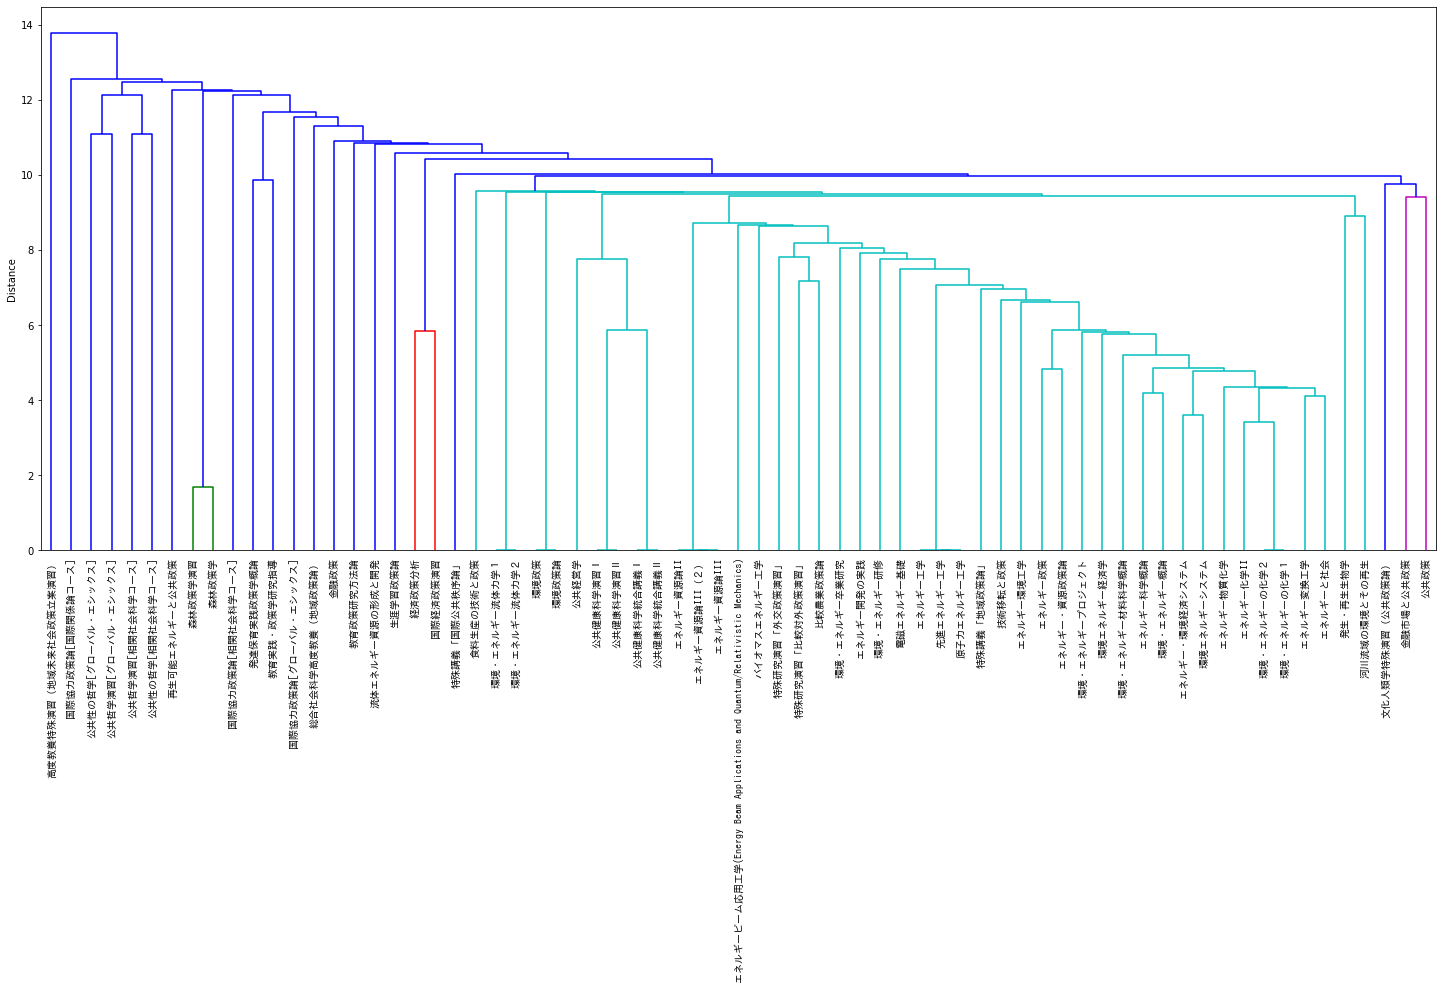

In [15]:
from scipy.spatial.distance import pdist

# 階層化クラスタリング
# 距離尺度を'euclidean'、距離計算は'single'
clusters = linkage(pdist(tfidf_matrix[ind,:], metric='euclidean'), method='single')

# デンドログラム
plt.figure(figsize=(25,10))
dend = dendrogram(clusters,  labels=labels)
for l in plt.gca().get_xticklabels(): l.set_fontproperties(fp) 
plt.ylabel('Distance');

In [16]:
from scipy.spatial.distance import squareform

# 距離行列
dist_matrix = pd.DataFrame(squareform(pdist(tfidf_matrix[ind,:], metric='euclidean')), columns=labels, index=labels)
dist_matrix

,金融政策,エネルギー政策,環境政策,再生可能エネルギーと公共政策,金融市場と公共政策,発達保育実践政策学概論,総合社会科学高度教養（地域政策論）,エネルギー科学概論,環境エネルギー経済学,高度教養特殊演習（地域未来社会政策立案演習）,...,エネルギー工学,エネルギーと社会,エネルギー開発の実践,公共経営学,河川流域の環境とその再生,エネルギー化学II,技術移転と政策,教育実践・政策学研究指導,生涯学習政策論,教育政策研究方法論
金融政策,0.000000,11.158532,13.093937,18.266284,14.672105,15.058640,15.380582,13.030481,13.995317,17.556592,...,14.452668,12.620131,14.319577,13.520415,13.839186,12.690234,10.912856,14.708960,13.859375,14.070812
エネルギー政策,11.158532,0.000000,9.830393,14.461822,14.034149,12.326722,12.718008,6.729087,8.447252,15.278068,...,9.185139,5.895327,8.974265,10.391682,10.803170,6.043940,6.654010,11.897014,10.829022,11.098341
環境政策,13.093937,9.830393,0.000000,17.486593,15.617161,14.102710,14.445971,11.912902,12.032234,16.743886,...,13.453751,11.462613,13.310675,12.446904,11.850267,11.539750,9.550613,13.728704,12.814292,13.042682
再生可能エネルギーと公共政策,18.266284,14.461822,17.486593,0.000000,15.451324,19.002431,19.258557,15.950702,16.748145,21.037197,...,17.132165,15.617272,17.020039,15.798186,14.756306,15.673976,15.919175,18.726538,18.066876,18.229577
金融市場と公共政策,14.672105,14.034149,15.617161,15.451324,0.000000,17.297606,17.578589,15.563995,16.380275,19.510983,...,16.772720,15.222096,16.658175,13.700273,16.247079,15.280267,13.839614,16.994058,16.264280,16.444825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
エネルギー化学II,12.690234,6.043940,11.539750,15.673976,15.280267,13.728703,14.081085,5.423407,7.449081,16.430112,...,8.276444,4.345988,8.041777,9.597905,10.041973,0.000000,8.989163,13.344218,12.401489,12.637341
技術移転と政策,10.912856,6.654010,9.550613,15.919175,13.839614,12.104778,12.503012,9.463427,10.753228,15.099568,...,11.342073,8.889922,11.171986,10.127420,10.549222,8.989163,0.000000,11.666899,10.575694,10.851303
教育実践・政策学研究指導,14.708960,11.897014,13.728704,18.726538,16.994058,9.855640,15.924459,13.668195,14.590922,18.034967,...,15.030160,13.277568,13.237478,14.136044,14.441231,13.344218,11.666899,0.000000,14.460581,13.125197
生涯学習政策論,13.859375,10.829022,12.814292,18.066876,16.264280,14.816124,15.143222,12.749444,13.734037,17.349029,...,14.199806,12.329744,14.064322,13.249774,13.574901,12.401489,10.575694,14.460581,0.000000,13.810961


## scikit-learnライブラリ
`scikit-learn`ライブラリには分類、回帰、クラスタリング、次元削減、前処理、モデル選択などの機械学習の処理を行うためのモジュールが含まれています。以下では、`scikit-learn`ライブラリの`KMeans`クラスを使ったk-means法によるクラスタリングについて説明します。

機械学習では、観察されたデータをよく表すようにモデルのパラメータの調整を行います。パラメータを調整することでモデルをデータに適合させるので、「学習」と呼ばれます。特に、観測されたデータの特徴のみからそのデータセットの構造やパターンをよく表すようなモデルを学習することを**教師なし学習**と呼びます。クラスタリングは教師なし学習の例です。クラスタリングでは、観測されたデータをクラスタと呼ばれる集合にグループ分けします。

`scikit-learn`ライブラリには機械学習に用いる代表的なデータセットが含まれています。以下では、`load_iris`関数により`iris`データセットをロードしています。`iris`データセットにはアヤメの花を4つの特徴量（'sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'）で表した150個の特徴量ベクトルが含まれています（`iris['data']`)。また、各花には3種類（0:'setosa', 1:'versicolor', 2:'virginica'）のいずれかがラベルとして付与されています（`iris['target']`)


`iris['data']`行列の各行は1つの花の特徴量ベクトルに対応しており、行数はデータの総数（この場合は150）を表します。1列目から4列目までの各列は上記の特徴量に対応しています。`scikit-learn`では、この特徴量ベクトルからなる行列を`NumPy`配列または`pandas`のデータフレームに格納し、入力データとして処理します。

In [6]:
from sklearn.datasets import load_iris
iris = load_iris() # データセットのロード
print(len(iris['data'])) # データの総数
print(iris['feature_names']) # 特徴量名
print(iris['data'][0:5]) # データ（先頭5行を表示）
print(iris['target_names']) # ラベル名
print(iris['target'][0:5], iris['target'][50:55], iris['target'][100:105]) # ラベル

150
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
['setosa' 'versicolor' 'virginica']
[0 0 0 0 0] [1 1 1 1 1] [2 2 2 2 2]


`iris['data']`の3列目と4列目の2つの特徴量（'petal length (cm)', 'petal width (cm)'）を用いて散布図でデータを可視化してみます。

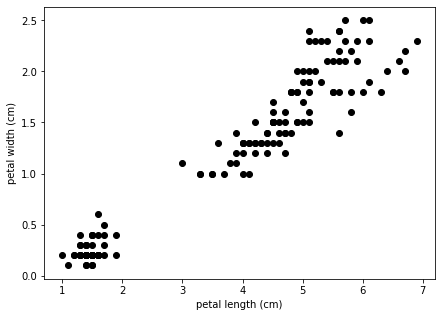

In [18]:
X_iris=iris['data'][:,2:4]
plt.figure(figsize=(7,5))
plt.xlabel(iris["feature_names"][2])
plt.ylabel(iris["feature_names"][3])
plt.scatter(X_iris[:,0],X_iris[:,1],c='black');

アヤメの種類（0:'setosa', 1:'versicolor', 2:'virginica'）ごとに色を変えて同様にデータを可視化してみると、種類ごとにグループになっており、アヤメの種類ごとに似た特徴量を持っていることがわかります。以下では、クラスタリングによりこれらのグループをクラスタとして自動的に抽出することを考えます。

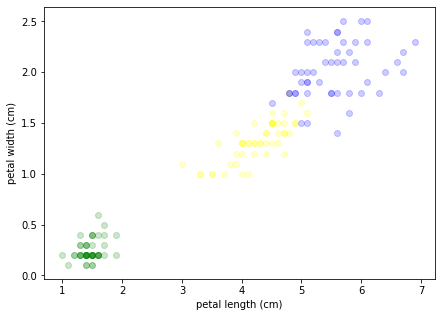

In [19]:
labels=iris['target']
plt.figure(figsize=(7,5))
plt.xlabel(iris["feature_names"][2])
plt.ylabel(iris["feature_names"][3])
plt.scatter(X_iris[labels==0,0],X_iris[labels==0,1],c='green', alpha=0.2)
plt.scatter(X_iris[labels==1,0],X_iris[labels==1,1],c='yellow', alpha=0.2)
plt.scatter(X_iris[labels==2,0],X_iris[labels==2,1],c='blue', alpha=0.2);

`scikit-learn`では、以下の手順でデータからモデルの学習を行います。
- 使用するモデルのクラスの選択
- モデルのハイパーパラメータの選択とインスタンス化
- データの準備
    - 教師なし学習では、特徴量データを準備
- モデルをデータに適合（`fit()`メソッド）
- モデルの評価
    - 教師なし学習では、`transform()`または`predict()`メソッドを用いて特徴量データのクラスタリングや次元削減などを行う

以下では、`iris`データセットの2つの特徴量（'petal length (cm)', 'petal width (cm)'）を元にアヤメのデータをk-means法によりクラスタリングする手続きを示しています。

モデルのクラスとして`KMeans`を選択し、モデルのハイパーパラメータの選択とインスタンス化では、引数`n_clusters`にハイパーパラメータとしてクラスタ数、ここでは3、を指定して`KMeans`クラスのインスタンスを作成しています。そして、`fit()`メソッドによりモデルを入力データ`X_iris`に適合させ、`predict()`メソッドを用いて各データが所属するクラスタ（0,1,2で表現）の情報をリストとして取得しています。最後に、クラスタリングの結果を元に、クラスタごとに異なる色でデータを可視化しています。

[KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

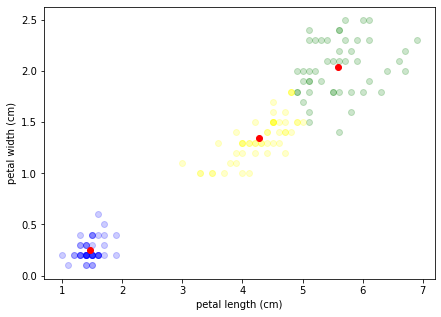

In [20]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3) 
model.fit(X_iris) 
clusters=model.predict(X_iris) 

# クラスタの可視化（irisデータセット、特徴量（'petal length (cm)', 'petal width (cm)'）、3クラスタ）
plt.figure(figsize=(7,5))
plt.xlabel(iris["feature_names"][2])
plt.ylabel(iris["feature_names"][3])

plt.scatter(X_iris[clusters==0,0],X_iris[clusters==0,1],c='blue', alpha=0.2)
plt.scatter(X_iris[clusters==1,0],X_iris[clusters==1,1],c='green', alpha=0.2)
plt.scatter(X_iris[clusters==2,0],X_iris[clusters==2,1],c='yellow', alpha=0.2)

plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c='red'); # クラスタの中心点
# print(model.inertia_) # コスト関数の値

## Q2 k-means法

### Q2.1 平方ユークリッド距離

$n$-次元ベクトル空間における、任意の2つのベクトル、$ \vec{x}=(x_1,x_2,...,x_n)$、$\vec{y}=(y_1,y_2,...,y_n)$、の間の平方ユークリッド距離$ \| \vec{x}- \vec{y}\|^2$は以下のように定義されます。

$\Sigma^{n}_{i=1}(x_{i}-y_{i})^2=\vec{x}\cdot\vec{x}+\vec{y}\cdot\vec{y}-2\vec{x}\cdot\vec{y}$

入力ベクトル $\vec{x}$, $\vec{y}$ をそれぞれ`NumPy` の配列として引数で受け取り、それらのベクトル間の平方ユークリッド距離を計算して返す関数 `squared_euclid` を完成させてください。

In [22]:
"""
import numpy as np
a = np.array([1,2,3,4,5])
b = np.array([6,7,8,9,10])
for i in range(5):
    print(a[i] + b[i])
"""

7
9
11
13
15


In [12]:
import numpy as np
import matplotlib.pyplot as plt
x = [1,2,3]
y = [0,1,-1]
squared_euclid(x, y)

18

In [67]:
z = np.array([1,4])
sum(z ** 2)
x = np.array([1,2])
y = np.array([3,4])
x - y

array([-2, -2])

In [68]:
def squared_euclid(x, y):
    x = np.array(x)
    y = np.array(y)
    z = x - y
    return sum(z ** 2)
"""
    euclidean_distance = 0
    
    for i in range(len(x)):
        euclidean_distance += np.dot(x[i], x[i]) + np.dot(y[i], y[i]) - 2*np.dot(x[i], y[i])
    return euclidean_distance### ベクトル間の平方ユークリッド距離を計算するコード ###
"""

'\n    euclidean_distance = 0\n    \n    for i in range(len(x)):\n        euclidean_distance += np.dot(x[i], x[i]) + np.dot(y[i], y[i]) - 2*np.dot(x[i], y[i])\n    return euclidean_distance### ベクトル間の平方ユークリッド距離を計算するコード ###\n'

### Q2.2 k-means法
以下では、k-means法によるクラスタリングを行う`kmeans`関数を実装します。`kmeans`関数では第1引数に入力`X`（データ数($m$)$\times$特徴量数($n$)の行列）、第2引数にクラスタ数を受け取り、以下の処理を行います。（引数には第3引数に中心への割り当てと中心点の更新の繰り返し数（既定値10）、第4引数に中心をランダムに選ぶ際のシード（既定値0）、を指定できますが省略可能です。）

- ***初期化***

まず、クラスタの数($K$)だけ中心を入力データからランダムに選び、それらを初期の中心$\mu^{(k)} (k=0,...,K-1)$とします。

- ***1. 中心への割り当て***

各データ$x^{(i)} (i=0,...,m-1)$と各中心$\mu^{(k)}$の平方ユークリッド距離を計算し、その結果を距離行列`d[i,k]`に代入します。距離行列`d`はデータを行、中心を列として、各データと各中心の距離を要素とする行列です。

距離行列`d[i,k]`の各行について、その行に対応するデータに最も近い中心をそのデータが属するクラスタの中心として選びます。これにより、各データ$x^{(i)}$がどのクラスタ中心$\mu^{(k)}$に属するかを表す以下の配列`clusters`を更新します。

データ$x^{(i)}$の最近接の中心が$\mu^{(k)}$であれば`clusters[i]=k`

この時、以下のように距離行列`d`の各行ごとにその行の最小値を持つ列のインデックスを`np.argmin`で取得することで配列`clusters`を作成できます。
```Python
clusters = np.argmin(d,axis=1)
```

- ***2. 中心の更新***

そして、各中心$\mu^{(k)}$に属するデータ$x^{(k,i)}$を用いて各中心を更新します

$\mu^{(k)}= \Sigma_{i} x^{(k,i)}/(\mu^{(k)}に属するデータ数)$

この時、`clusters`配列とインデックス参照を用いて、中心$\mu^{(k)}$に属するデータの特徴ベクトル集合を入力`X`から以下のように取得できます。
```Python
X[clusters==k,:]
```
これらの特徴ベクトルの平均のベクトル（ヒント:`np.mean`)を新たな中心$\mu^{(k)}$のベクトルとします。

k-means法では、上記のデータの中心への割り当てと中心の更新を繰り返すことで、クラスタリングを行います。繰り返し処理が終わったら、`kmeans`関数は、各データの所属するクラスタを表す配列`clusters`、各クラスタ中心のベクトルを行とする行列`centers`、最終的なコスト関数の値`cost`を返します。上記に従って、`kmeans`関数を完成させてください。

In [70]:
def kmeans(X, n_clusters, max_iter=10, rand_seed=0): 
    ### 引数：
    # X: 入力（データ数x特徴量数(要素数)の行列）
    # n_clusters: クラスタ数
    # max_iter: 中心への割り当てと中心の更新の繰り返し数
    # rand_seed: 中心をランダムに選ぶ際のシード
    
    # クラスタ数のだけ中心を入力データからランダムに選ぶ
        # 補1: k-means++の場合は、この中心を選び方を変更
        # 補2: また、クラスタ数が比較的小さい時は異なる初期中心を試し
        # 最終的にコストが小さくなる初期中心を採用するのがよい
    np.random.seed(rand_seed)    
    centers=X[np.random.choice(X.shape[0],n_clusters),:] #n_clusters
        
    # 入力データの各特徴量ベクトルと中心ベクトルの距離行列（入力データ数xクラスタ数）の初期化
    d = np.zeros((X.shape[0], n_clusters))
    
    # 各データの所属するクラスタ（中心）を表す配列
    clusters=np.zeros(X.shape[0]) #m
    
    for l in range(max_iter): # max_iterだけ繰り返し
        # 1. 中心への割り当て
        for i in range(len(X)):
            for j in range(n_clusters):
                d[i,j] = squared_euclid(X[i], centers[j])### 入力データiの特徴量ベクトルと中心kのベクトルの平方ユークリッド距離を計算して、d[i,k]を更新するコード
                #print(X[i], centers[j])
                #d[i,j] = np.linalg.norm(np.array(X[i])-np.array(centers[j]))
            #print(d[i], np.argmin(d[i]))
            clusters[i] = np.argmin(np.array(d[i]))###  各データiがどの中心kに属するかを表す配列clustersを更新（clusters[i]=k)するコード
                            
                           
        # 2. 中心の更新
        #print(len(clusters), clusters)
#        print(centers)
        for i in range(n_clusters): 
#            print(i)
#            print(clusters==i)
#            print(X[clusters==i,:])
            centers[i,:] = np.mean(X[clusters==i,:], axis=0)### 中心kに属するデータiだけを用いて中心kのベクトルcenters[k,:]を更新するコード
                # 補: この時中心を可視化すると更新ごとの中心の変化を観察できる
            #plt.scatter(centers[i:,0], centers[i:,1], c='red')
#        print(centers)

    cost = np.sum((X - centers[np.argmin(d,axis=1),:])**2) # コストの計算
    #print(cost)
    return clusters, centers, cost 

`kmeans`関数が完成したら以下を実行して、上記の`scikit-learn`の`KMeans`を用いてえられたのと同様のクラスタリング結果がえられていることを確認してください（クラスタの色の割り当ては異なっていても構いません）。最終的なコスト関数の値は$\simeq31$となります。

86.39021984551397


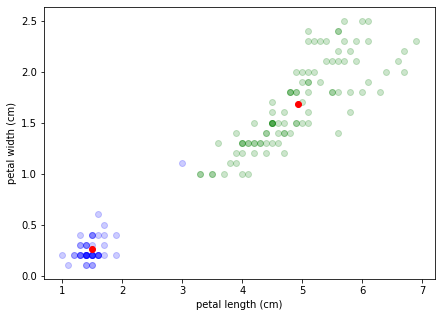

In [80]:
iris = load_iris() 
X_iris=iris['data'][:,2:4]
clusters, centers, loss=kmeans(X_iris,2)

#コスト関数の値
print(loss)

# クラスタの可視化# クラスタの可視化（irisデータセット、特徴量（'petal length (cm)', 'petal width (cm)'）、3クラスタ）
plt.figure(figsize=(7,5))
plt.xlabel(iris["feature_names"][2])
plt.ylabel(iris["feature_names"][3])
    
plt.scatter(X_iris[clusters==0,0],X_iris[clusters==0,1],c='blue', alpha=0.2)
plt.scatter(X_iris[clusters==1,0],X_iris[clusters==1,1],c='green', alpha=0.2)
plt.scatter(X_iris[clusters==2,0],X_iris[clusters==2,1],c='yellow', alpha=0.2)
plt.scatter(centers[:,0], centers[:,1], c='red'); # クラスタの中心点

### Q2.3 エルボー法
クラスタリングにおいて、クラスタ数を変化させた時のクラスタリングのコストの変化に基づいて、最適なクラスタ数を決定する方法をエルボー法と呼びます。エルボー法では、クラスタ数を増やしていった時にコストが最も大きく減少する時のクラスタ数を採用します。以下の`elbow`関数は、Q2.2で作成した`kmeans`関数を用いて、クラスタ数を1から1つずつ増やしていった時のクラスタリングのコストの変化を可視化します。`elbow`関数を完成させてください。

irisデータセットの2つの特徴量（'petal length (cm)', 'petal width (cm)'）から花の特徴量ベクトルを作成し、k-means法でクラスタリングするとコストが最も大きく減少するのはクラスタ数を1から2にした時であることがわかります。この時、コスト関数の値は約550から約86まで減少しています。実際の花の種類は3種類ですが、'versicolor'と'virginica'の種類の花は特徴量空間上では近傍に分布しているため、全体を'setosa'とそれ以外（'versicolor', 'virginica'）の2つクラスタとみなした時、全体のデータを大きく2つに識別でき、クラスタリングのコストが大きく減少しています。

2


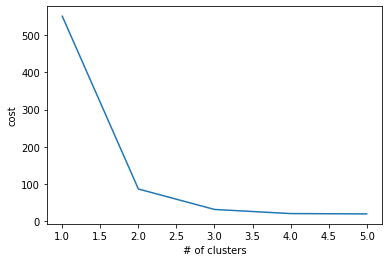

In [88]:
def elbow(X, K):
    ### 引数：
    # X: 入力データ
    # K: 最大のクラスタ数    
    
    # 各クラスタ数でのコストをいれるリスト
    costs=[]
    max_diff = -100000
    best_class_num = -1
    previous_cost = -1
    for i in range(1, K+1):
        #loss = kmeans(X_iris,i)[2]### 1からKまでクラスタ数kのそれぞれで入力データをkmeans法でクラスタリングした時のコストを求めるコード ###
        clusters, centers, loss = kmeans(X_iris,i)
        if previous_cost == -1:
            previous_cost = loss
        else:
            tmp = previous_cost - loss
            if tmp > max_diff:
                max_diff = tmp
                best_class_num = i
            previous_cost = loss
        costs.append(loss)# kmeans関数の引数はkmeans(X, k)のように与える

    # クラスタ数 vs. コストの可視化    
    plt.xlabel("# of clusters")
    plt.ylabel("cost")
    plt.plot(range(1,K+1),costs);
    return best_class_num

iris = load_iris() 
X_iris=iris['data'][:,2:4]
n_best = elbow(X_iris, 5)
print(n_best)